<a href="https://colab.research.google.com/github/slp22/deep-learning-project/blob/main/dl_diabetic_retinopathy_mvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Deep Learning | MVP

# Diabetic Retinopathy<a id='top'></a> 

## **Analysis Goal**  
The client, ...

**RQ:** ? 

## **Process**
**Data source:** 


**Models:** 


## **Preliminary Conclusions**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import pickle
import PIL
import tensorflow as tf
import zipfile
print("TensorFlow version:", tf.__version__)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)

# from tensorflow import keras
from tensorflow.keras.preprocessing import image as IMG
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense, Flatten, Conv2D
# from tensorflow.keras import Model
# from tensorflow.keras.models import Sequential

from PIL import Image
%pylab inline


import seaborn as sns
pd.set_option('display.max_colwidth', None)
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']  # or svg
sns.set(context='notebook', style='whitegrid')

# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import confusion_matrix, accuracy_score
# from sklearn.model_selection import train_test_split


TensorFlow version: 2.8.2
Pandas version: 1.3.5
Numpy version: 1.21.6
Populating the interactive namespace from numpy and matplotlib


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
type(uploaded)

## 1 | Dataset: [Diabetic Retinopathy Retinal Images](https://www.kaggle.com/datasets/sachinkumar413/diabetic-retinopathy-preprocessed-dataset)<a id='1'></a>  

In [17]:
filepath = '/tmp/sample-dr'
# filepath = 'raw-data-diabetic-retinopathy'
filepath

'/tmp/sample-dr'

In [37]:
# https://github.com/PurpleGrace/Deep_Learning_Tools_Image_Classification/blob/main/code/1.EDA_Sample_Images.ipynb

data = {'image_path':[],'disease':[]}
for disease in os.listdir(filepath):
    print(disease)
    if disease != '.DS_Store':        
        for image in os.listdir(filepath +"/"+disease):
            if image != '.DS_Store':
                data['image_path'].append(filepath +"/"+disease+"/"+ image)
                data['disease'].append(disease)
data = pd.DataFrame(data)    
data.head()

mild-dr
.ipynb_checkpoints
no-dr
moderate-dr


,image_path,disease
0,/tmp/sample-dr/mild-dr/Mild DR_2351.jpg,mild-dr
1,/tmp/sample-dr/mild-dr/Mild DR_1746.jpg,mild-dr
2,/tmp/sample-dr/mild-dr/Mild DR_1191.jpg,mild-dr
3,/tmp/sample-dr/mild-dr/Mild DR_1042.jpg,mild-dr
4,/tmp/sample-dr/no-dr/No DR_2168.jpg,no-dr


In [38]:
data.describe()


,image_path,disease
count,11,11
unique,11,3
top,/tmp/sample-dr/mild-dr/Mild DR_2351.jpg,mild-dr
freq,1,4


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


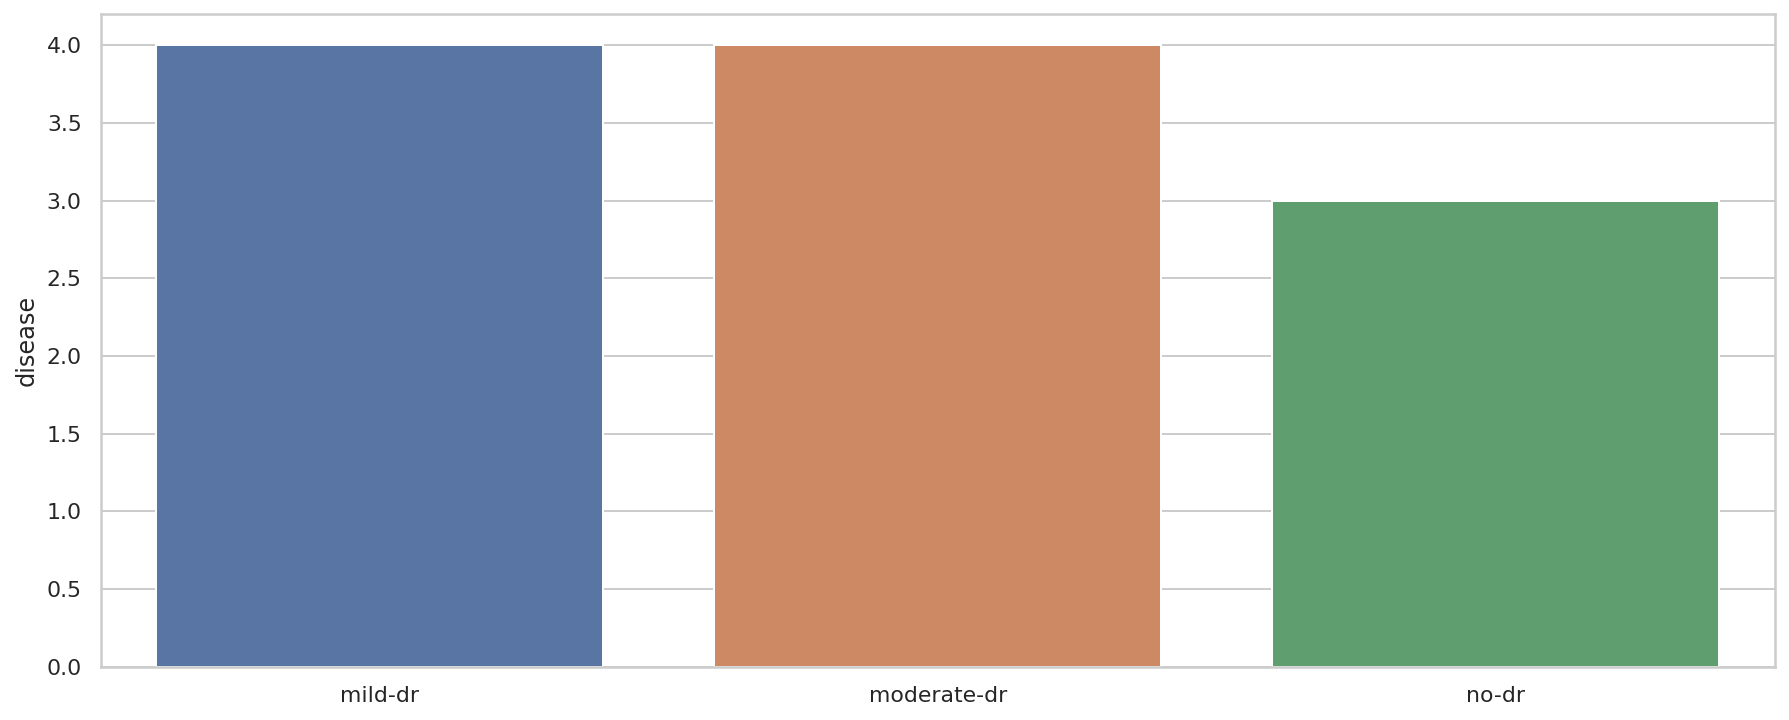

In [46]:
plt.figure(figsize=(15,6))
sns.barplot(data.disease.value_counts().index,
            data.disease.value_counts(),
            palette=None);


In [66]:
import os
import urllib.request
urllib.request.urlretrieve('https://www.kaggle.com/datasets/sachinkumar413/diabetic-retinopathy-preprocessed-dataset/download?datasetVersionNumber=1')
os.listdir()

  #  https://www.kaggle.com/datasets/sachinkumar413/diabetic-retinopathy-preprocessed-dataset/download?datasetVersionNumber=1

['.config', '.ipynb_checkpoints']

In [ ]:
# unzip raw data file from Google Drive

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/DR_raw_data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

Healthy Eye
type: <class 'PIL.Image.Image'>


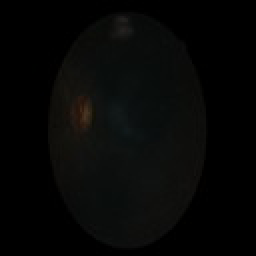

In [59]:
# import one healthy image

path = '/tmp/sample-dr/no-dr/No DR_2009.jpg'

healthy_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
   target_size=(256, 256))
  #  interpolation="nearest")
print('Healthy Eye')
print('type:', type(healthy_image))
healthy_image 


Moderate Diabetic Retinopthy
type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


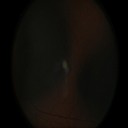

In [51]:
# import one moderate DR image

path = '/tmp/sample-dr/moderate-dr/Moderate DR_2576.jpg'

moderate_image = tf.keras.preprocessing.image.load_img(
   path)
  #  grayscale=False, 
  #  color_mode="rgb", 
  #  target_size=(256, 256), 
  #  interpolation="nearest")

print('Moderate Diabetic Retinopthy')
print('type:', type(moderate_image))
moderate_image 


In [ ]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb#scrollTo=pb2Af2lsUShk

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

After EDA, import images ...

In [48]:
# read in all images
# https://keras.io/api/preprocessing/image/

directory = '/tmp/sample-dr'
data = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False )

print('type:', type(data), '\n')
data

Found 11 files belonging to 4 classes.
type: <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'> 



<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [49]:
class_names = data.class_names
class_names

['.ipynb_checkpoints', 'mild-dr', 'moderate-dr', 'no-dr']

In [ ]:
# https://www.tensorflow.org/jvm/api_docs/java/org/tensorflow/op/data/BatchDataset

# convert healthy_image to numpy array

img = healthy_image
healthy_image_array = tf.keras.preprocessing.image.img_to_array(img, 
                                                                data_format=None, 
                                                                dtype=None)
print('type:', type(healthy_image_array))
healthy_image_array

https://www.h5py.org/
https://www.tensorflow.org/tutorials/images/cnn
https://www.tensorflow.org/tutorials/images/classification
https://www.tensorflow.org/tutorials/images/transfer_learning

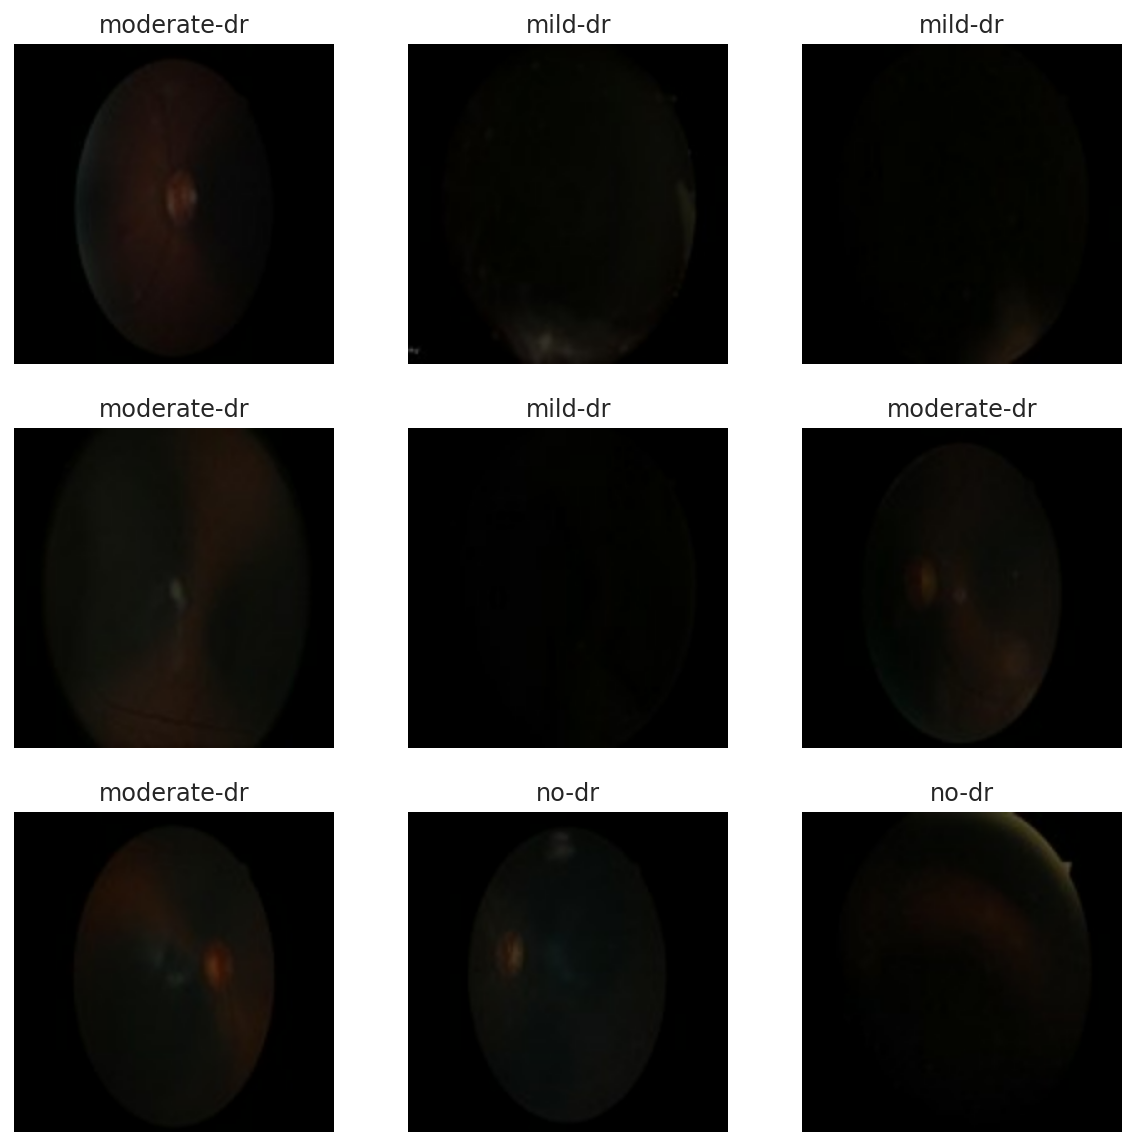

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AttributeError: ignored

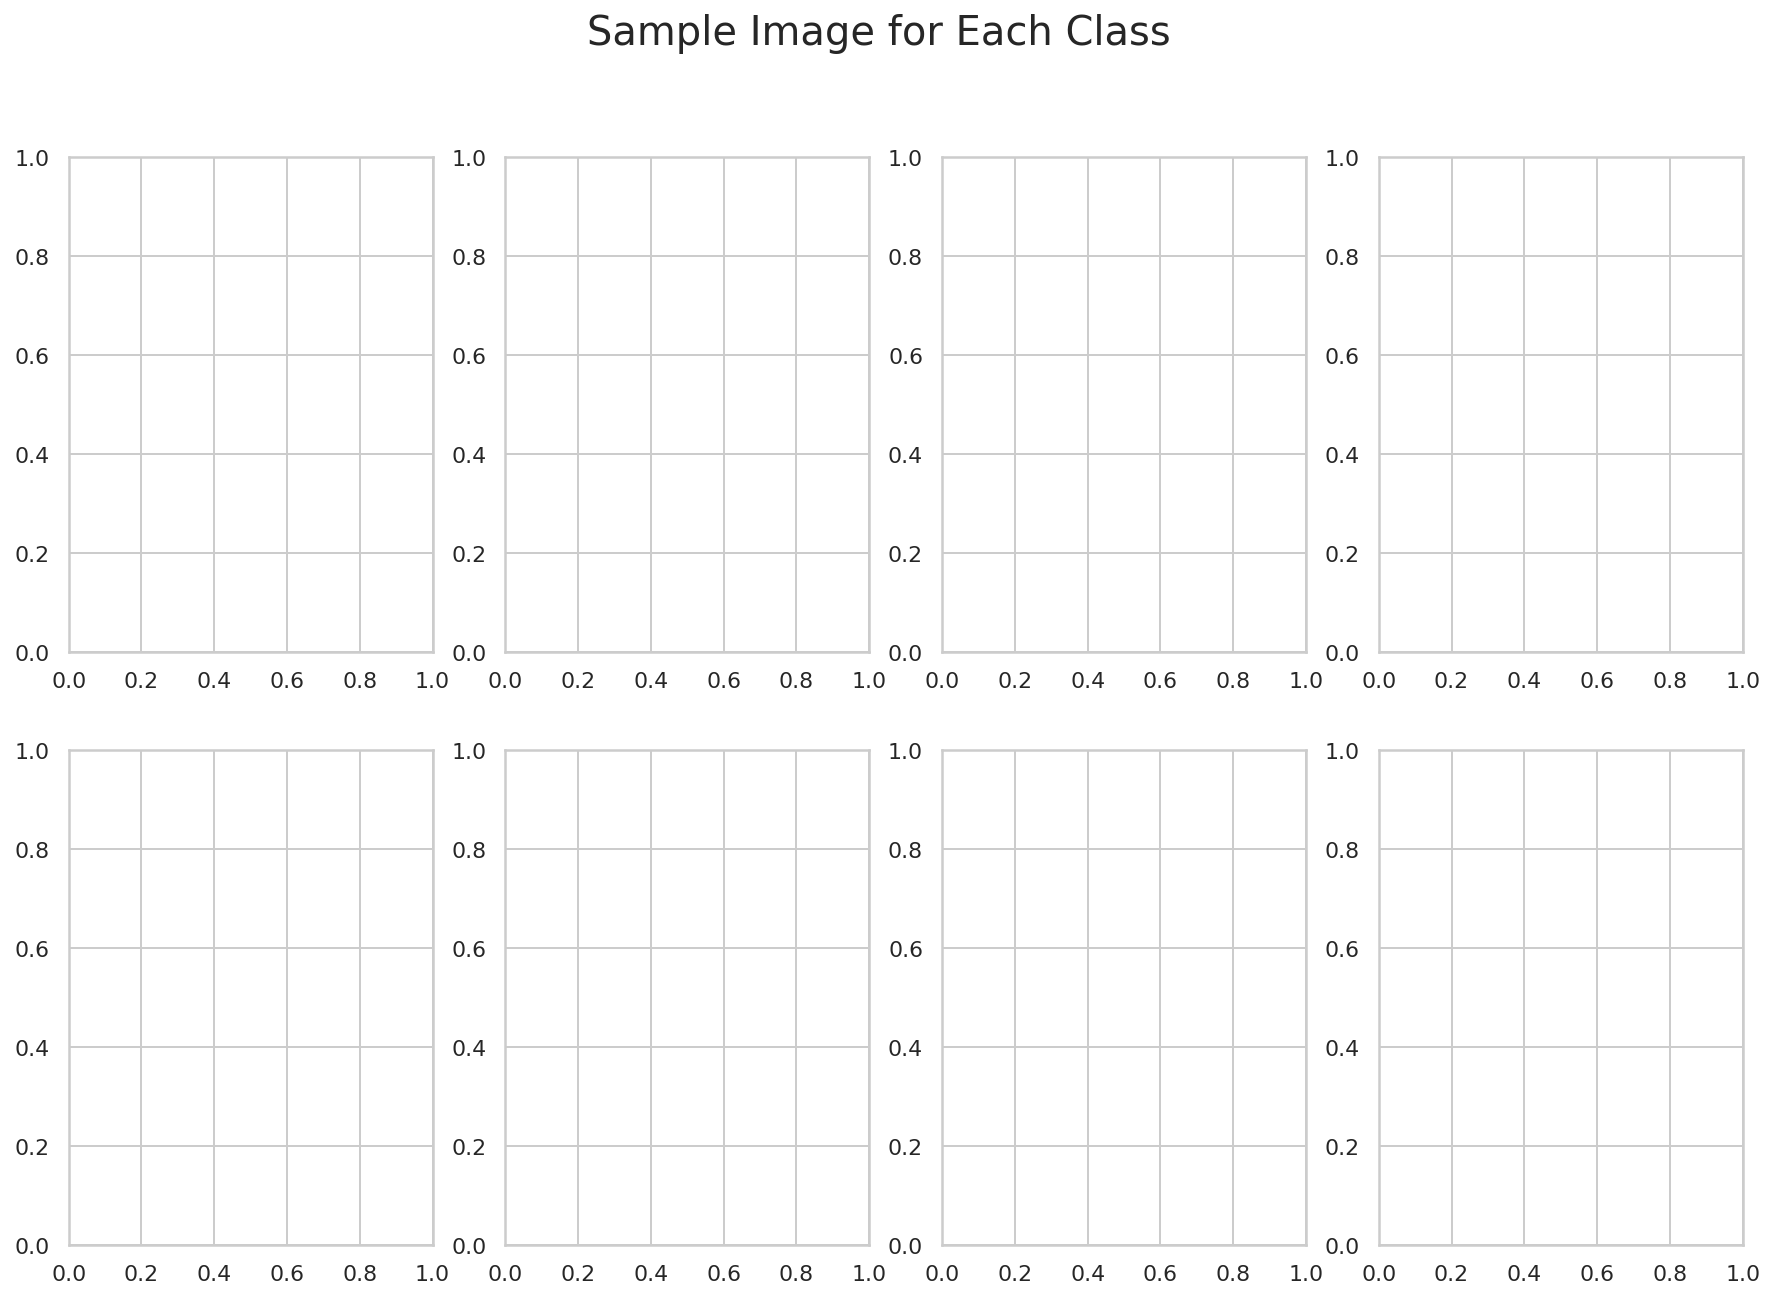

In [61]:
fig, ax = plt.subplots(2, 4,figsize= (15,10))
fig.suptitle('Sample Image for Each Class', fontsize=20)

for n,cate in enumerate(data.category.unique()):
    ax = plt.subplot(2,4,n+1)
    index = random.choice(data[data.disease == cate].index)
    img = mpimg.imread(data.image_path[index])
    print(data.image_path[index])
    plt.imshow(img)
    plt.title(cate)
    plt.axis('off')

In [62]:
for image_batch, labels_batch in data:
  print('image_batch.shape', image_batch.shape)
  print('labels_batch.shape', labels_batch.shape)
  break

image_batch.shape (11, 256, 256, 3)
labels_batch.shape (11,)


image_batch = tensor 32 images, sized 256x256, 3 RBG colors

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       

In [11]:
dataset = {'image_path':[],'category':[]}
for category in os.listdir(filepath):
    print(category)
    if category != '.DS_Store':        
        for image in os.listdir(filepath +"/"+category):
            if image != '.DS_Store':
                dataset['image_path'].append(filepath +"/"+category+"/"+ image)
                dataset['category'].append(category)
dataset = pd.DataFrame(dataset)    
dataset.head()

.config
Moderate DR_1584.jpg


NotADirectoryError: ignored

In [ ]:
# unzip raw data file from Google Drive

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/DR_raw_data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

Healthy Eye
type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


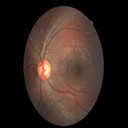

In [ ]:
# import one healthy image

path = '/tmp/raw-data/No DR/No DR.jpg'

healthy_image = tf.keras.preprocessing.image.load_img(
   path)
  #  grayscale=False, 
  #  color_mode="rgb", 
  #  target_size=(256, 256), 
  #  interpolation="nearest")
print('Healthy Eye')
print('type:', type(healthy_image))
healthy_image 


Severe Diabetic Retinopthy
type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


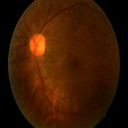

In [ ]:
# import one severe DR image

path = '/tmp/raw-data/Severe DR/Severe DR.jpg'

severe_image = tf.keras.preprocessing.image.load_img(
   path)
  #  grayscale=False, 
  #  color_mode="rgb", 
  #  target_size=(256, 256), 
  #  interpolation="nearest")

print('Severe Diabetic Retinopthy')
print('type:', type(severe_image))
severe_image 


In [ ]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb#scrollTo=pb2Af2lsUShk

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

After EDA, import images ...

In [ ]:
# read in all images
# https://keras.io/api/preprocessing/image/

directory = '/tmp/raw-data'
data = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False )

print('type:', type(data), '\n')
data

Found 13970 files belonging to 5 classes.
type: <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'> 



<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
class_names = data.class_names
class_names

['Mild DR', 'Moderate DR', 'No DR', 'Proliferative DR', 'Severe DR']

In [ ]:
# https://www.tensorflow.org/jvm/api_docs/java/org/tensorflow/op/data/BatchDataset

# convert healthy_image to numpy array

img = healthy_image
healthy_image_array = tf.keras.preprocessing.image.img_to_array(img, 
                                                                data_format=None, 
                                                                dtype=None)
print('type:', type(healthy_image_array))
healthy_image_array

https://www.h5py.org/
https://www.tensorflow.org/tutorials/images/cnn
https://www.tensorflow.org/tutorials/images/classification
https://www.tensorflow.org/tutorials/images/transfer_learning

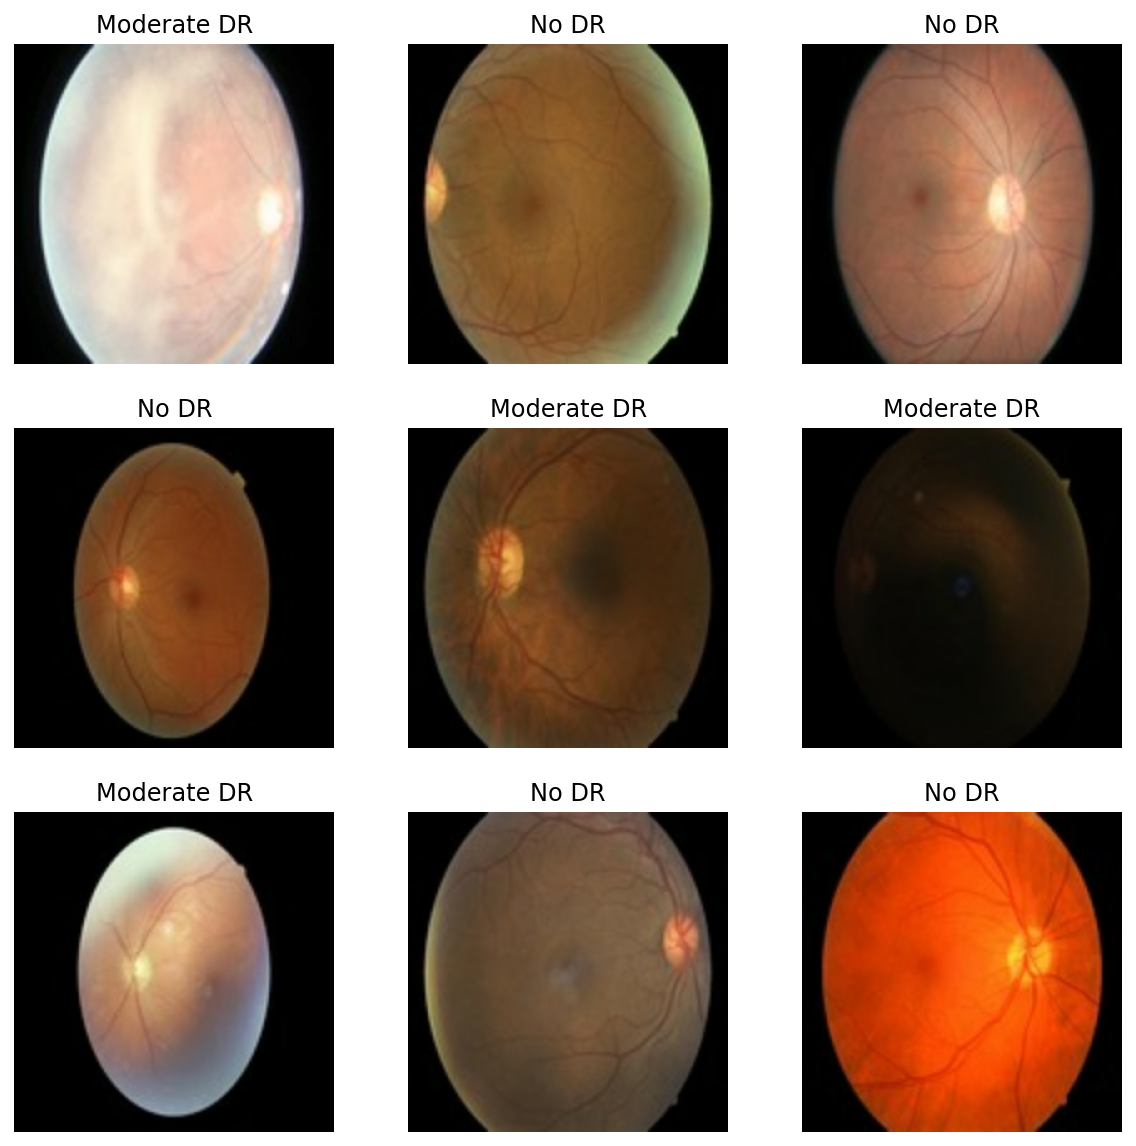

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in data:
  print('image_batch.shape', image_batch.shape)
  print('labels_batch.shape', labels_batch.shape)
  break

image_batch.shape (32, 256, 256, 3)
labels_batch.shape (32,)


image_batch = tensor 32 images, sized 256x256, 3 RBG colors

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 2 | Exploratory Data Analysis<a id='2'></a>  

### Data Selection <a id='2'></a>  

In [ ]:
# pickle


### Preprocessing<a id='tp'></a>  

In [ ]:
# read in pickle
